In [ ]:
%%capture
!pip install langchain langchain_core langchain_community langgraph langchain-google-genai

In [ ]:

os.environ["GOOGLE_API_KEY"]=google_api_key

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm=ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    temperature=0

)

In [ ]:
llm.invoke("what is gen ai?").content

'Gen AI, short for **generative artificial intelligence**, is a type of AI that can create new content, rather than just analyzing or classifying existing data.  This content can take many forms, including:\n\n* **Text:**  Writing stories, articles, poems, code, scripts, summaries, translations, etc.  Examples include ChatGPT, Bard, and Jasper.\n* **Images:** Generating realistic or stylized images from text descriptions (prompts). Examples include DALL-E 2, Midjourney, and Stable Diffusion.\n* **Audio:** Creating music, sound effects, and speech. Examples include Jukebox and Murf.ai.\n* **Video:** Generating short video clips.  This is a rapidly developing area.\n* **3D models:** Creating three-dimensional objects and scenes.\n\nGen AI works by learning patterns and structures from massive datasets.  It then uses this learned knowledge to generate new content that shares similar characteristics but is not a direct copy.  Different techniques are used depending on the type of content b

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    application:str
    experience_level:str
    skill_match:str
    response:str

In [ ]:
from langgraph.graph import StateGraph

workflow=StateGraph(State)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
def categorize_experience(state:State)->State :
  print("\n ---categorizing experience level of candidate-----\n")
  prompt=ChatPromptTemplate.from_template(
      "Based on the following job application , categorize the candidate as 'entry-level', 'mid-level','senior-level'"
      "here is the input:"
      "Application:{application}"
  )
  chain=prompt|llm
  experience_level=chain.invoke({"application":state["application"]}).content
  print(f"experience_level:{experience_level}")
  return {"experience_level":experience_level}

def accessSkillSet(state:State)->State:
  print("\n---accessing skill set of candidate----\n")
  prompt=ChatPromptTemplate.from_template(
      """
      Based on the job application for python developer ,access the candidate skill set.
      response with "match" or "no-match".no other output should be generated.only one word output should be generated.
      here is the input application:
      Application:{application}
      """
  )
  chain=prompt|llm
  skill_match=chain.invoke({"application":state["application"]}).content
  print(f"skill_match:{skill_match}")
  return {"skill_match":skill_match}


def schedule_hr_interview(state: State) -> State:
  print("\nScheduling the interview : ")
  return {"response" : "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
  print("Escalating to recruiter")
  return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
  print("Sending rejecting email")
  return {"response" : "Candidate doesn't meet JD and has been rejected."}


In [ ]:
workflow.add_node("categorize_experience",categorize_experience)


In [ ]:
workflow.add_node("accessSkillSet",accessSkillSet)
workflow.add_node("schedule_hr_interview",schedule_hr_interview)
workflow.add_node("escalate_to_recruiter",escalate_to_recruiter)
workflow.add_node("reject_application",reject_application)

In [ ]:
def rout_app(state:State)->str:
  if state['skill_match']=="match":
    return "schedule_hr_interview"
  elif state['experience_level']=="senior-level":
    return "escalate_to_recruiter"
  else:
    return "reject_application"

In [ ]:
workflow.set_entry_point("categorize_experience")
workflow.add_edge("categorize_experience","accessSkillSet")
workflow.add_conditional_edges("accessSkillSet",rout_app)


In [ ]:
from langgraph.graph import END

In [ ]:
workflow.add_edge("accessSkillSet", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)
workflow.add_edge("schedule_hr_interview", END)

In [ ]:
app=workflow.compile()

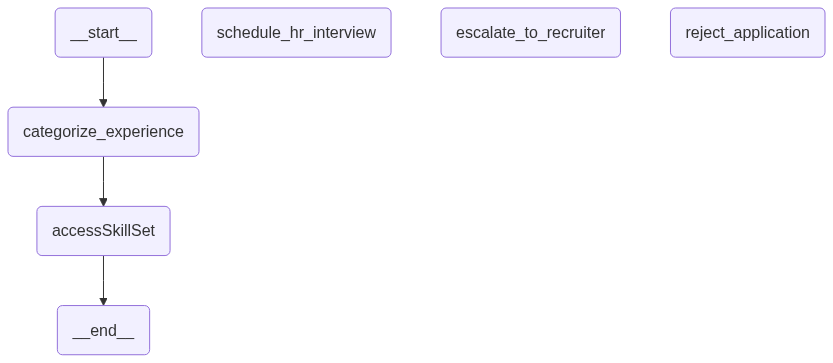

In [ ]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [ ]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

In [ ]:
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


 ---categorizing experience level of candidate-----

experience_level:Senior-level

---accessing skill set of candidate----

skill_match:no-match
Sending rejecting email


Computed Results :
Application: I have 10 years of experience in software engineering with expertise in JAVA
Experience Level: Senior-level
Skill Match: no-match
Response: Candidate doesn't meet JD and has been rejected.


In [ ]:
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


 ---categorizing experience level of candidate-----

experience_level:Based solely on "I have experience in software engineering with expertise in Python," the candidate should be categorized as **mid-level**.  While "experience" is vague,  "expertise" suggests more than entry-level knowledge.  Senior-level roles typically require significantly more experience and a broader skillset.

---accessing skill set of candidate----

skill_match:match

Scheduling the interview : 


Computed Results :
Application: I have experience in software engineering with expertise in Python
Experience Level: Based solely on "I have experience in software engineering with expertise in Python," the candidate should be categorized as **mid-level**.  While "experience" is vague,  "expertise" suggests more than entry-level knowledge.  Senior-level roles typically require significantly more experience and a broader skillset.
Skill Match: match
Response: Candidate has been shortlisted for an HR interview.
